### Modeling time Series -XGBoost <a id='modeling'>

## Contents<a id='Contents'></a>
* [Time Series - Modeling](#modeling)
  * [Contents](#Contents)
    * [Imports](#imports)
    * [Load The EDA - Crime reports Data](#load_data)
    

### Imports<a id='imports'>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pyarrow as pa
import pyarrow.parquet as pq
from pylab import rcParams
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time

from math import sqrt

# Import mean_squared_error and ARIMA

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

C:\Users\anita\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Load Data<a id='load_data'>

In [2]:
#load dataset
df_crimes_summary = pd.read_csv('crimes_summary.csv', parse_dates=['occurred_date_time'])

In [3]:
#this dataframe list top ten crimes which occur in the zip code 78701 under census_tract 11 which falls under council_district 9.
#Top ten crimes are : ASSAULT BY CONTACT,ASSAULT WITH INJURY,BURGLARY OF VEHICLE,CRIMINAL MISCHIEF,DISTURBANCE - OTHER,DWI,POSS OF DRUG PARAPHERNALIA,THEFT,VIOL CITY ORDINANCE - OTHER,WARRANT ARREST NON TRAFFIC

In [4]:
df_crimes_summary.head()

,incident_report_number,crime_type,ucr_code,family_violence,location_type,address,zip_code,council_district,sector,district,...,clearance_status,clearance_date,occurred_date_time,reported_date_time,month,year,hour,year_month,occurred_day,cal_month
0,20223650465,ASSAULT WITH INJURY,900,N,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,700 BLOCK E 7TH ST,78701,9,GE,2,...,N,2023-01-03T00:00:00.000,2022-12-31 09:24:00,2022-12-31 09:24:00,December,2022,9,2022-12,31,12
1,20223650192,DWI,2100,N,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,E 9TH ST / N IH 35 SVRD SB,78701,9,CH,2,...,C,2022-12-31T00:00:00.000,2022-12-31 02:39:00,2022-12-31 02:39:00,December,2022,2,2022-12,31,12
2,20223641477,ASSAULT BY CONTACT,902,N,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,708 E 6TH ST,78701,9,GE,2,...,N,2023-01-03T00:00:00.000,2022-12-30 23:40:00,2022-12-30 23:40:00,December,2022,23,2022-12,30,12
3,20223641378,DISTURBANCE - OTHER,3401,N,RESTAURANT,414 E 6TH ST,78701,9,GE,2,...,NaN,NaN,2022-12-30 22:28:00,2022-12-30 23:01:00,December,2022,22,2022-12,30,12
4,20223640858,ASSAULT WITH INJURY,900,N,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,400 E 8TH ST,78701,9,GE,1,...,N,2023-01-04T00:00:00.000,2022-12-30 15:55:00,2022-12-30 15:55:00,December,2022,15,2022-12,30,12


In [5]:
df_crimes_types=df_crimes_summary[['occurred_date_time','crime_type','family_violence','hour','occurred_day','cal_month','year_month','year']]

In [6]:
df_crimes_types.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30680 entries, 0 to 30679
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   occurred_date_time  30680 non-null  datetime64[ns]
 1   crime_type          30680 non-null  object        
 2   family_violence     30680 non-null  object        
 3   hour                30680 non-null  int64         
 4   occurred_day        30680 non-null  int64         
 5   cal_month           30680 non-null  int64         
 6   year_month          30680 non-null  object        
 7   year                30680 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 1.9+ MB


### Preparing Time Series for the crime Burglary of Vehicle<a id='choosing_burglary'>

In [7]:

df_burglary = df_crimes_types.loc[(df_crimes_types['crime_type'] == 'BURGLARY OF VEHICLE')]

In [8]:
df_burglary.shape

(2963, 8)

In [9]:
df_burglary.head(5)

,occurred_date_time,crime_type,family_violence,hour,occurred_day,cal_month,year_month,year
5,2022-12-30 00:00:00,BURGLARY OF VEHICLE,N,0,30,12,2022-12,2022
12,2022-12-27 17:00:00,BURGLARY OF VEHICLE,N,17,27,12,2022-12,2022
27,2022-12-21 16:35:00,BURGLARY OF VEHICLE,N,16,21,12,2022-12,2022
29,2022-12-21 02:00:00,BURGLARY OF VEHICLE,N,2,21,12,2022-12,2022
30,2022-12-19 08:46:00,BURGLARY OF VEHICLE,N,8,19,12,2022-12,2022


In [10]:
df_burglary.year_month.unique()

array(['2022-12', '2022-11', '2022-10', '2022-09', '2022-08', '2022-07',
       '2022-06', '2022-05', '2022-04', '2022-03', '2022-02', '2022-01',
       '2021-12', '2021-11', '2021-10', '2021-09', '2021-08', '2021-07',
       '2021-06', '2021-05', '2021-04', '2021-03', '2021-02', '2021-01',
       '2020-12', '2020-11', '2020-10', '2020-09', '2020-08', '2020-07',
       '2020-06', '2020-05', '2020-04', '2020-03', '2020-02', '2020-01',
       '2019-12', '2019-11', '2019-10', '2019-09', '2019-08', '2019-07',
       '2019-06', '2019-05', '2019-04', '2019-03', '2019-02', '2019-01',
       '2018-12', '2018-11', '2018-10', '2018-09', '2018-08', '2018-07',
       '2018-06', '2018-05', '2018-04', '2018-03', '2018-02', '2018-01',
       '2017-12', '2017-11', '2017-10', '2017-09', '2017-08', '2017-07',
       '2017-06', '2017-05', '2017-04', '2017-03', '2017-02', '2017-01',
       '2016-12', '2016-11', '2016-10', '2016-09', '2016-08', '2016-07',
       '2016-06', '2016-05', '2016-04', '2016-03', 

### Daily level dataset preparation<a id='daily_prep'>

In [11]:
df_burglary['occurred_date'] = pd.to_datetime(df_burglary['occurred_date_time'], format='%Y-%m-%d').dt.floor('D')

In [12]:
df_burglary.shape

(2963, 9)

### Group Aggregarion<a id='gp_agg'>

In [13]:
df_burglary_gp = df_burglary.groupby(['occurred_date']).agg(
    burglary_count=('crime_type', 'count'),
    
    
 ).reset_index()

In [14]:
df_burglary_gp.head()

,occurred_date,burglary_count
0,2013-01-01,1
1,2013-01-03,1
2,2013-01-04,2
3,2013-01-05,2
4,2013-01-07,1


In [15]:
df_burglary_gp.describe()

,burglary_count
count,1779.000000
mean,1.665542
std,1.100158
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,11.000000


In [16]:
df_burglary_gp.set_index('occurred_date',inplace=True)

In [17]:
df_burglary_gp.head()

,burglary_count
occurred_date,
2013-01-01,1
2013-01-03,1
2013-01-04,2
2013-01-05,2
2013-01-07,1


In [18]:
split_date = '01-Jan-2021'
df_burglary_gp_train = df_burglary_gp.loc[df_burglary_gp.index <= split_date].copy()
df_burglary_gp_test = df_burglary_gp.loc[df_burglary_gp.index > split_date].copy()

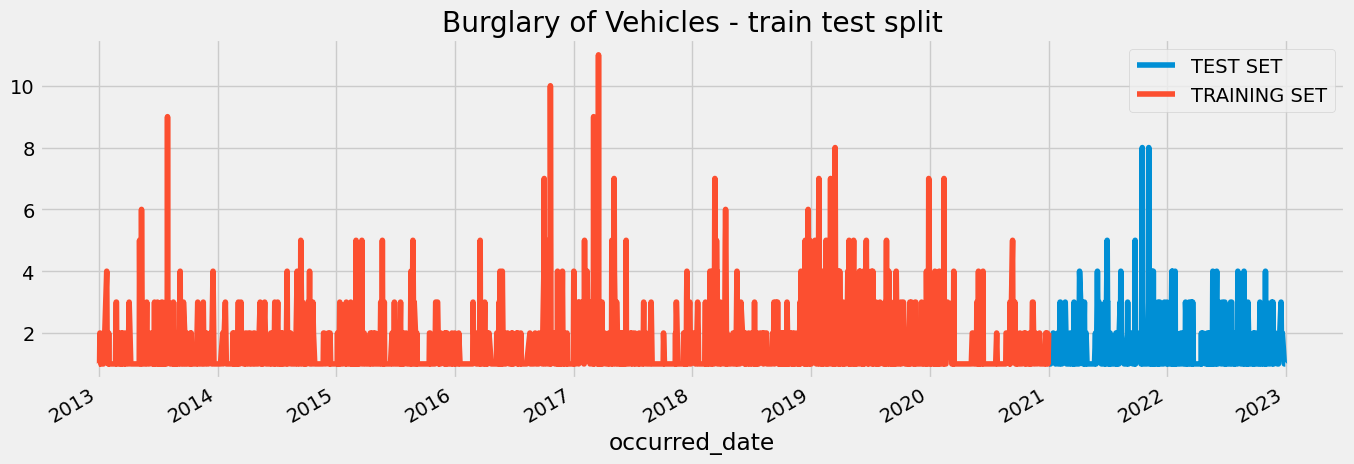

In [19]:
_ = df_burglary_gp_test \
    .rename(columns={'burglary_count': 'TEST SET'}) \
    .join(df_burglary_gp_train.rename(columns={'burglary_count': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Burglary of Vehicles - train test split')

In [38]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['occurred_date'] = df.index
    df['dayofweek'] = df['occurred_date'].dt.dayofweek
    df['quarter'] = df['occurred_date'].dt.quarter
    df['month'] = df['occurred_date'].dt.month
    df['year'] = df['occurred_date'].dt.year
    df['dayofyear'] = df['occurred_date'].dt.dayofyear
    df['dayofmonth'] = df['occurred_date'].dt.day
    df['weekofyear'] = df['occurred_date'].dt.weekofyear
    
    df['burglary_1_ds_lag'] = df['burglary_count'].shift(1)
    df['burglary_2_ds_lag'] = df['burglary_count'].shift(2)
    
    df['burglary_1_ds_mean'] = df['burglary_count'].rolling(window = 1).mean()
    df['burglary_2_ds_mean'] = df['burglary_count'].rolling(window = 2).mean()
    
    df['burglary_1_ds_std'] = df['burglary_count'].rolling(window = 1).std()
    df['burglary_2_ds_std'] = df['burglary_count'].rolling(window = 2).std()
    
    df['burglary_1_ds_max'] = df['burglary_count'].rolling(window = 1).max()
    df['burglary_2_ds_max'] = df['burglary_count'].rolling(window = 2).max()
    
    
    df['burglary_1_ds_min'] = df['burglary_count'].rolling(window = 1).min()
    df['burglary_2_ds_min'] = df['burglary_count'].rolling(window = 2).min()
 
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear' , 'burglary_1_ds_lag' , 'burglary_2_ds_lag' , 'burglary_1_ds_mean',
           "burglary_2_ds_mean","burglary_1_ds_std" ,"burglary_2_ds_std",
           "burglary_1_ds_max","burglary_2_ds_max","burglary_1_ds_min","burglary_2_ds_min"]]
    if label:
        y = df[label]
        return X, y
    return X

In [39]:
X_train, y_train = create_features(df_burglary_gp_train, label='burglary_count')
X_test, y_test = create_features(df_burglary_gp_test, label='burglary_count')

In [40]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1440, 17), (1440,), (339, 17), (339,))

In [41]:
X_train.tail()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,burglary_1_ds_lag,burglary_2_ds_lag,burglary_1_ds_mean,burglary_2_ds_mean,burglary_1_ds_std,burglary_2_ds_std,burglary_1_ds_max,burglary_2_ds_max,burglary_1_ds_min,burglary_2_ds_min
occurred_date,,,,,,,,,,,,,,,,,
2020-12-24,3,4,12,2020,359,24,52,2.0,1.0,1.0,1.5,NaN,0.707107,1.0,2.0,1.0,1.0
2020-12-27,6,4,12,2020,362,27,52,1.0,2.0,2.0,1.5,NaN,0.707107,2.0,2.0,2.0,1.0
2020-12-28,0,4,12,2020,363,28,53,2.0,1.0,2.0,2.0,NaN,0.000000,2.0,2.0,2.0,2.0
2020-12-30,2,4,12,2020,365,30,53,2.0,2.0,1.0,1.5,NaN,0.707107,1.0,2.0,1.0,1.0
2021-01-01,4,1,1,2021,1,1,53,1.0,2.0,2.0,1.5,NaN,0.707107,2.0,2.0,2.0,1.0


In [42]:
X_train.head(15)

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,burglary_1_ds_lag,burglary_2_ds_lag,burglary_1_ds_mean,burglary_2_ds_mean,burglary_1_ds_std,burglary_2_ds_std,burglary_1_ds_max,burglary_2_ds_max,burglary_1_ds_min,burglary_2_ds_min
occurred_date,,,,,,,,,,,,,,,,,
2013-01-01,1,1,1,2013,1,1,1,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN
2013-01-03,3,1,1,2013,3,3,1,1.0,NaN,1.0,1.0,NaN,0.000000,1.0,1.0,1.0,1.0
2013-01-04,4,1,1,2013,4,4,1,1.0,1.0,2.0,1.5,NaN,0.707107,2.0,2.0,2.0,1.0
2013-01-05,5,1,1,2013,5,5,1,2.0,1.0,2.0,2.0,NaN,0.000000,2.0,2.0,2.0,2.0
2013-01-07,0,1,1,2013,7,7,2,2.0,2.0,1.0,1.5,NaN,0.707107,1.0,2.0,1.0,1.0
2013-01-15,1,1,1,2013,15,15,3,1.0,2.0,1.0,1.0,NaN,0.000000,1.0,1.0,1.0,1.0
2013-01-18,4,1,1,2013,18,18,3,1.0,1.0,2.0,1.5,NaN,0.707107,2.0,2.0,2.0,1.0
2013-01-19,5,1,1,2013,19,19,3,2.0,1.0,2.0,2.0,NaN,0.000000,2.0,2.0,2.0,2.0
2013-01-25,4,1,1,2013,25,25,4,2.0,2.0,4.0,3.0,NaN,1.414214,4.0,4.0,4.0,2.0


### Create XGBoost Model<a id='create_xgboost'>

In [43]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=20,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

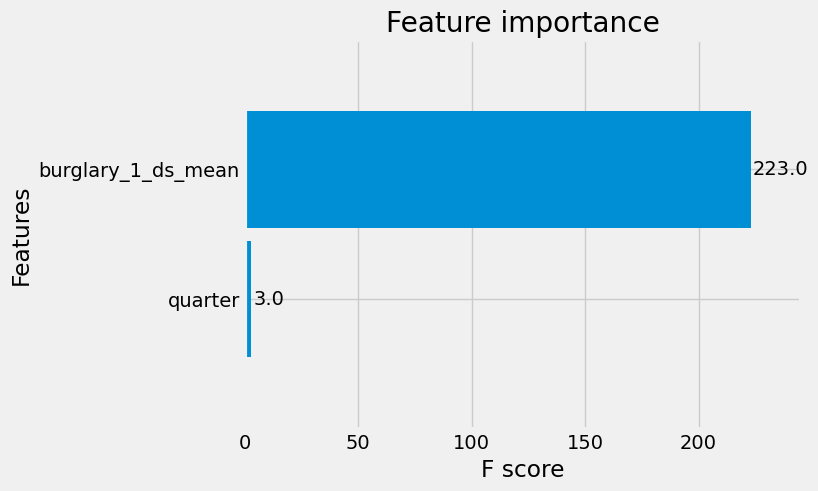

In [45]:
_ = plot_importance(reg, height=0.9 ,max_num_features = 17)

### Forecast on Test set<a id='forecast_on_test'>

In [46]:
df_burglary_gp_test['burglary_count_prediction'] = reg.predict(X_test)
df_burglary_all = pd.concat([df_burglary_gp_test, df_burglary_gp_train], sort=False)

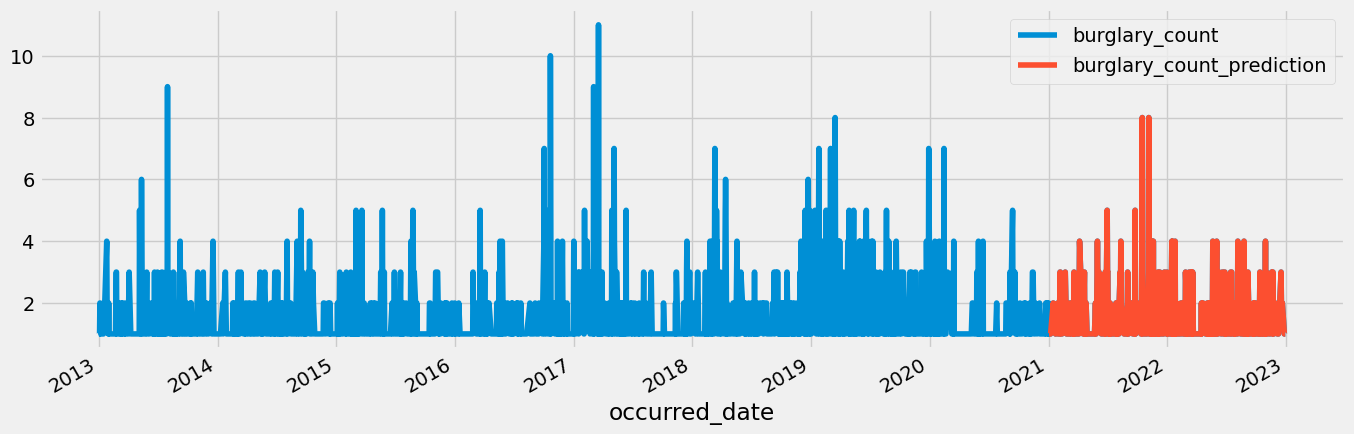

In [47]:
_ = df_burglary_all[['burglary_count','burglary_count_prediction']].plot(figsize=(15, 5))

### Error Metrics<a id='error_metrics'>

In [48]:
mean_squared_error(y_true=df_burglary_gp_test['burglary_count'],
                   y_pred=df_burglary_gp_test['burglary_count_prediction'])

5.281288510417342e-10

In [49]:
mean_absolute_error(y_true=df_burglary_gp_test['burglary_count'],
                   y_pred=df_burglary_gp_test['burglary_count_prediction'])

1.5846044264711813e-05

In [50]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [51]:
mean_absolute_percentage_error(y_true=df_burglary_gp_test['burglary_count'],
                   y_pred=df_burglary_gp_test['burglary_count_prediction'])

0.0010203682215867843

## Linear Regression<a id='linear_regression'>

In [ ]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X_train,y_train)

In [37]:
np.isnan(X_train).any()

dayofweek              False
quarter                False
month                  False
year                   False
dayofyear              False
dayofmonth             False
weekofyear             False
burglary_7_ds_lag       True
burglary_14_ds_lag      True
burglary_7_ds_mean      True
burglary_14_ds_mean     True
burglary_7_ds_std       True
burglary_14_ds_std      True
burglary_7_ds_max       True
burglary_14_ds_max      True
burglary_7_ds_min       True
burglary_14_ds_min      True
dtype: bool